# HW-3

In [51]:
import wikipedia
import warnings
warnings.filterwarnings("ignore")
import re

In [2]:
? wikipedia

In [183]:
#wikipedia.languages()

In [184]:
languages = wikipedia.languages().keys()
languages

dict_keys(['aa', 'ab', 'ace', 'ady', 'ady-cyrl', 'aeb', 'aeb-arab', 'aeb-latn', 'af', 'ak', 'aln', 'als', 'am', 'an', 'ang', 'anp', 'ar', 'arc', 'arn', 'arq', 'ary', 'arz', 'as', 'ase', 'ast', 'atj', 'av', 'avk', 'awa', 'ay', 'az', 'azb', 'ba', 'ban', 'bar', 'bat-smg', 'bbc', 'bbc-latn', 'bcc', 'bcl', 'be', 'be-tarask', 'be-x-old', 'bg', 'bgn', 'bh', 'bho', 'bi', 'bjn', 'bm', 'bn', 'bo', 'bpy', 'bqi', 'br', 'brh', 'bs', 'bto', 'bug', 'bxr', 'ca', 'cbk-zam', 'cdo', 'ce', 'ceb', 'ch', 'cho', 'chr', 'chy', 'ckb', 'co', 'cps', 'cr', 'crh', 'crh-cyrl', 'crh-latn', 'cs', 'csb', 'cu', 'cv', 'cy', 'da', 'de', 'de-at', 'de-ch', 'de-formal', 'din', 'diq', 'dsb', 'dtp', 'dty', 'dv', 'dz', 'ee', 'egl', 'el', 'eml', 'en', 'en-ca', 'en-gb', 'eo', 'es', 'es-formal', 'et', 'eu', 'ext', 'fa', 'ff', 'fi', 'fit', 'fiu-vro', 'fj', 'fo', 'fr', 'frc', 'frp', 'frr', 'fur', 'fy', 'ga', 'gag', 'gan', 'gan-hans', 'gan-hant', 'gcr', 'gd', 'gl', 'glk', 'gn', 'gom', 'gom-deva', 'gom-latn', 'gor', 'got', 'grc', 'gs

In [218]:
languages = ['el','gom','hy','ja','ko','zh','ps',
             'ru','be','kk','bg','mk','ba','sr','tt','tg','sl',
            'af','en','fr','la','no','pl','pt','es','ca','de']

In [219]:
def get_texts_for_lang(lang, n=10): # функция для скачивания статей из википедии
    wikipedia.set_lang(lang)
    wiki_content = []
    pages = wikipedia.random(n)
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
        except wikipedia.exceptions.WikipediaException:
            #print('Skipping page {}'.format(page_name))
            continue

        wiki_content.append('{}\n{}'.format(page.title, page.content.replace('==', '')))

    return wiki_content

In [252]:
wiki_texts = {}
for lang in languages:
    wiki_texts[lang] = get_texts_for_lang(lang, 50)
    print(lang, len(wiki_texts[lang]))

el 48
gom 50
hy 48
ja 43
ko 48
zh 50
ps 50
ru 45
be 49
kk 50
bg 49
mk 50
ba 50
sr 47
tt 47
tg 50
sl 49
af 50
en 46
fr 49
la 49
no 49
pl 47
pt 47
es 47
ca 49
de 46


In [ ]:
TEST = {}
for lang in languages:
    TEST[lang] = get_texts_for_lang(lang, 10)
    print(lang, len(TEST[lang]))

In [120]:
import pickle as pkl

In [121]:
with open('wiki_3_100.pkl', 'wb') as f:
    pkl.dump(wiki_texts, f)

In [122]:
with open('wiki_3_100.pkl', 'rb') as f:
    wiki_texts = pkl.load(f)

In [224]:
with open('wiki_more_10.pkl', 'wb') as f:
    pkl.dump(wiki_texts, f)

In [ ]:
with open('wiki_more_10.pkl', 'rb') as f:
    wiki_texts = pkl.load(f)

In [33]:
from collections import defaultdict
from string import punctuation, digits
punctuation = set(punctuation + '«»—…“”\n\t' + digits)

## Первый способ: частотный словарь

In [40]:
import codecs
import collections
import sys

In [145]:
from sklearn.metrics import classification_report, confusion_matrix

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [107]:
#wiki_texts['kk']

In [188]:
def tokenize(text):
    text = re.sub(r'[^\w\s]','',text).replace('\n', '')
    text = re.sub(r'[\s]{2,}',' ',text)
    return text.split(' ')

In [255]:
total_freqs = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
for lang in wiki_texts.keys():
    for article in wiki_texts[lang]:
        for word in tokenize(article.replace('\n', '').lower()):
            total_freqs[lang][word] += 1
#            freqs[word] += 1
for lang in wiki_texts.keys():
    summ = sum(total_freqs[lang].values())
    for word in total_freqs[lang]:
        total_freqs[lang][word] = total_freqs[lang][word]/summ

In [256]:
sum(total_freqs['ru'].values())

0.9999999999998496

In [257]:
len(total_freqs['ru'])

6632

In [244]:
for word in sorted(total_freqs['kk'], key=lambda w: total_freqs['kk'][w], reverse=True)[:5]:
    print('{}\t{}'.format(total_freqs['kk'][word], word))

0.016666666666666666	және
0.016666666666666666	су
0.011111111111111112	сыртқы
0.011111111111111112	дереккөздер
0.011111111111111112	коды


In [230]:
def predict_language_word(text, total_freqs):
    text_words = tokenize(text)
    variants = {}
    
    for lang in total_freqs.keys():
        summ = 0
        for word in text_words:
            if word in total_freqs[lang]:
                summ += total_freqs[lang][word]
        variants[lang] = summ
    
    return max(variants, key=lambda x: variants[x])
#     return lang2sim

In [247]:
def print_result(corpus, fnctn, source):
    true_labels = []
    predicted_labels = []

    for lang in wiki_texts.keys():
        for text in corpus[lang]:
            true_labels.append(lang)
            predicted_labels.append(fnctn(text, source))
    print(classification_report(true_labels, predicted_labels))

    labels = list(set(true_labels))

    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
                annot=True, 
                fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
    plt.title("Confusion matrix")
    plt.show()

             precision    recall  f1-score   support

         af       0.93      1.00      0.96        50
         ba       0.94      0.98      0.96        50
         be       1.00      0.86      0.92        49
         bg       0.68      1.00      0.81        49
         ca       1.00      0.37      0.54        49
         de       1.00      0.98      0.99        46
         el       0.88      0.96      0.92        48
         en       0.55      1.00      0.71        46
         es       0.45      1.00      0.62        47
         fr       0.97      0.73      0.84        49
        gom       1.00      0.72      0.84        50
         hy       1.00      0.94      0.97        48
         ja       1.00      0.79      0.88        43
         kk       1.00      0.90      0.95        50
         ko       1.00      0.81      0.90        48
         la       1.00      0.80      0.89        49
         mk       0.98      0.98      0.98        50
         no       0.96      0.98      0.97   

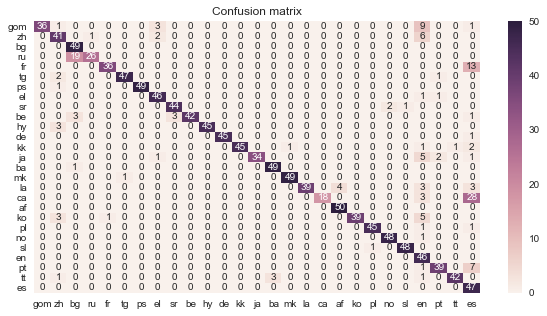

In [258]:
print_result(wiki_texts, predict_language_word, total_freqs)

In [259]:
print_result(TEST, predict_language_word, total_freqs)

KeyError: 'el'

## Второй способ: частотные символьные n-grams

In [154]:
from itertools import islice, tee

def make_ngrams(text):
    N = 3 # задаем длину n-граммы
    text = re.sub(r'[^\w\s]','',text).replace('\n', '')
    text = re.sub(r'[\s]{2,}',' ',text)
    ngrams = zip(*(islice(seq, index, None) for index, seq in enumerate(tee(text, N))))
    ngrams = [''.join(x) for x in ngrams]
    return ngrams

In [155]:
make_ngrams('Это какой-то текст???')

['Это',
 'то ',
 'о к',
 ' ка',
 'как',
 'ако',
 'кой',
 'ойт',
 'йто',
 'то ',
 'о т',
 ' те',
 'тек',
 'екс',
 'кст']

In [260]:
total_ngrams = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))

for lang in wiki_texts.keys():
    for article in wiki_texts[lang]:
        for word in make_ngrams(article.replace('\n', '').lower()):
            total_ngrams[lang][word] += 1

for lang in wiki_texts.keys():
    summ = sum(total_ngrams[lang].values())
    for word in total_ngrams[lang]:
        total_ngrams[lang][word] = total_ngrams[lang][word]/summ

In [238]:
for word in sorted(total_ngrams['kk'], key=lambda w: total_ngrams['kk'][w], reverse=True)[:20]:
    print('{}\t{}'.format(total_ngrams['kk'][word], word))

0.006181318681318681	ала
0.006181318681318681	ың 
0.005494505494505495	нда
0.005265567765567766	ан 
0.005265567765567766	ағы
0.005036630036630037	ынд
0.004807692307692308	ды 
0.004807692307692308	ер 
0.004578754578754579	дер
0.00434981684981685	асы
0.004120879120879121	 жа
0.004120879120879121	ғы 
0.003891941391941392	ның
0.003891941391941392	ары
0.003891941391941392	лық
0.003663003663003663	ылы
0.003663003663003663	ық 
0.003434065934065934	ен 
0.003205128205128205	 ба
0.003205128205128205	не 


In [212]:
def predict_language_ngrams(text, total_freqs):
    text_words = make_ngrams(text)
    variants = {}
    
    for lang in total_ngrams.keys():
        summ = 0
        for word in text_words:
            if word in total_ngrams[lang]:
                summ += total_ngrams[lang][word]
        variants[lang] = summ
    
    return max(variants, key=lambda x: variants[x])
#     return lang2sim

             precision    recall  f1-score   support

         af       0.93      1.00      0.96        50
         ba       0.98      1.00      0.99        50
         be       0.98      0.98      0.98        49
         bg       0.92      0.98      0.95        49
         ca       1.00      0.67      0.80        49
         de       0.85      1.00      0.92        46
         el       1.00      0.98      0.99        48
         en       0.61      0.96      0.75        46
         es       0.70      1.00      0.82        47
         fr       0.92      1.00      0.96        49
        gom       1.00      0.74      0.85        50
         hy       1.00      1.00      1.00        48
         ja       1.00      0.81      0.90        43
         kk       1.00      1.00      1.00        50
         ko       1.00      0.73      0.84        48
         la       0.83      1.00      0.91        49
         mk       0.94      1.00      0.97        50
         no       0.96      0.98      0.97   

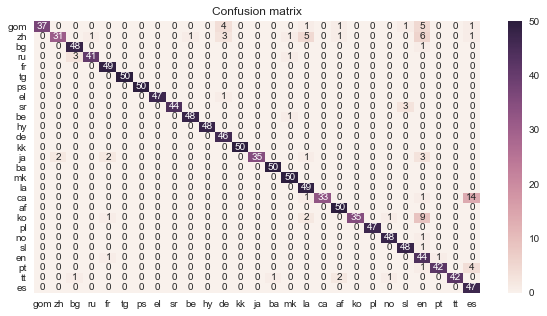

In [261]:
print_result(wiki_texts, predict_language_ngrams, total_ngrams)

             precision    recall  f1-score   support

         af       0.91      1.00      0.95        10
         ba       1.00      1.00      1.00        10
         be       1.00      0.89      0.94         9
         bg       1.00      0.90      0.95        10
         ca       0.77      1.00      0.87        10
         de       0.80      1.00      0.89         8
         el       1.00      1.00      1.00        10
         en       0.60      1.00      0.75         9
         es       1.00      0.89      0.94         9
         fr       0.90      1.00      0.95         9
        gom       1.00      0.70      0.82        10
         hy       1.00      1.00      1.00         9
         ja       0.75      0.33      0.46         9
         kk       1.00      1.00      1.00        10
         ko       1.00      0.67      0.80         9
         la       0.83      1.00      0.91        10
         mk       0.82      1.00      0.90         9
         no       0.77      1.00      0.87   

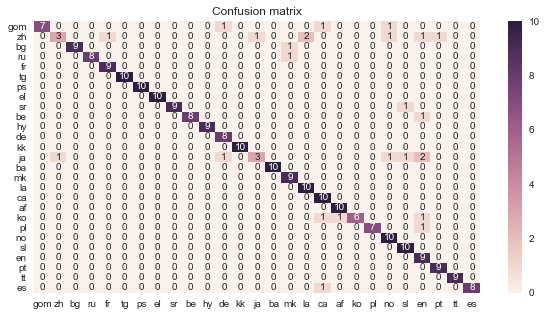

In [251]:
print_result(TEST, predict_language_ngrams, total_ngrams)